# CSCE 676 — Project Checkpoint 1  
## Dataset Comparison, Selection, and EDA (Directed Graph + Simple Causal Framing)

**Student:** Jaehoon Lee

**Selected direction:** *Stable + fast to execute* using a **directed SNAP graph** (Slashdot).  
- **Course techniques:** directed graph mining (SCC/WCC, PageRank/HITS, reciprocity), basic visualization  
- **Beyond-course technique:** **causal effect estimation (simple propensity-score weighting / regression adjustment)** framed as:  
  *Do high-centrality nodes (measured on a “past” graph) receive more “future” incoming edges?*  

> Important: The causal analysis here is **assumption-conditional** because the dataset is observational and has no true timestamps.  
> We use a **train/test edge split** as a *pseudo-temporal* proxy (train = “past”, test = “future”).


---
## 0. Collaboration Declaration

On my honor, I declare the following resources were used for this notebook:

1) **Collaborators:** None.  
2) **Web / Material Sources:**  
   - SNAP datasets index: https://snap.stanford.edu/data/index.html  
   - Slashdot0902 dataset page: https://snap.stanford.edu/data/soc-Slashdot0902.html  
   - NetworkX documentation: https://pypi.org/project/networkx/  
   - scikit-learn documentation: https://scikit-learn.org/stable/  
3) **AI Tools:** ChatGPT (OpenAI) — used as a supplementary writing and coding assistant for refining explanations, improving clarity, and cleaning code structure. All research design decisions, dataset selection, methodological choices, and analytical interpretations were independently developed by the author.
4) **Citations for any papers used:** None (this checkpoint uses dataset + library documentation only).


---
## 1. Requirements Map (A–F)

- **(A)** Identify 3 candidate datasets (course alignment + beyond-course technique)  
- **(B)** Compare them in a required table (tasks, quality, feasibility, bias, ethics)  
- **(C)** Select 1 dataset + justify + trade-offs  
- **(D)** Perform EDA on selected dataset only (basics, cleaning, bias)  
- **(E)** Initial insights + hypotheses + potential RQs  
- **(F)** GitHub repo link placeholder

This notebook is designed to be **clean, reproducible, and fully runnable in Colab**.


---
## 2. (A) Identification of Candidate Datasets (3 candidates)

### Candidate 1 (Selected): SNAP Slashdot0902 (Directed social network)
- **Name & source:** Slashdot Zoo (soc-Slashdot0902) — SNAP  
- **Dataset URL:** https://snap.stanford.edu/data/soc-Slashdot0902.html  
- **Course alignment:** Directed graph mining; PageRank/HITS; SCC/WCC connectivity; reciprocity; (optional) community intuition  
- **Beyond-course technique (planned/feasible):** *Assumption-conditional causal effect estimation* on graphs (propensity weighting / regression / doubly robust later)  
- **Size & structure:** ~82K nodes, ~948K directed edges (sparse)  
- **Data types:** directed edge list (user → user)  
- **Target variable(s):** none (unsupervised), but we can define outcomes (e.g., “future in-link gain”) via an edge split  
- **Licensing / constraints:** research use; follow SNAP terms; avoid re-identification / deanonymization

### Candidate 2: Amazon Reviews’23 (Text + user–item interactions)
- **Name & source:** Amazon Reviews’23 (McAuley Lab) via HuggingFace  
- **Dataset URL:** https://huggingface.co/datasets/McAuley-Lab/Amazon-Reviews-2023  
- **Course alignment:** Text mining, embeddings, basic supervised/unsupervised text analyses  
- **Beyond-course technique (example):** Topic modeling or transformer embeddings; causal ML (e.g., effect of verified purchase on helpful votes)  
- **Size & structure:** extremely large (category configs; typically millions of reviews); JSON-like records  
- **Data types:** review text/title, rating, timestamps, helpful votes, user_id, product ids (asin/parent_asin)  
- **Target variable(s):** rating/helpfulness (supervised possible) or unsupervised structure  
- **Licensing / constraints:** public research use; large scale; may require streaming + HF rate limits; do not deanonymize users

### Candidate 3: UCSD Amazon Reviews 2014 (Classic JSON dump)
- **Name & source:** UCSD Amazon review data (Julian McAuley)  
- **Dataset URL:** https://cseweb.ucsd.edu/~jmcauley/datasets/amazon/  
- **Course alignment:** Text mining; (optional) item co-occurrence / frequent patterns on products or tokens  
- **Beyond-course technique (example):** Topic models, sequence modeling, or MinHash/LSH for near-duplicate review/product neighborhoods  
- **Size & structure:** large (multiple categories; millions of reviews depending on subset); gzipped JSON lines  
- **Data types:** review text, ratings, reviewers/products, timestamps, metadata (varies by file)  
- **Target variable(s):** rating/helpfulness (if included) or unsupervised exploration  
- **Licensing / constraints:** academic/research use; older schema inconsistencies; privacy care (no deanonymization)


---
## 3. (B) Comparative Analysis of Datasets

| Dimension | SNAP Slashdot0902 (Directed graph) | Amazon Reviews’23 | UCSD Amazon 2014 |
|---|---|---|---|
| **Supported tasks (course vs beyond)** | Course: PR/HITS, SCC/WCC, reciprocity, communities. Beyond: **causal effect prototype** on “future edges” | Course: text/embeddings. Beyond: causal ML / topic modeling | Course: text mining. Beyond: topic modeling / LSH |
| **Data quality issues** | missing meaning of edge type; possible bots; no timestamps | noisy text; selection bias; huge scale | noisy text; older; schema variation |
| **Algorithmic feasibility** | feasible in Colab with sampling/efficient routines; large but manageable | streaming + heavy I/O; library constraints | manageable, but parsing/cleaning needed |
| **Bias considerations** | social network sampling bias; homophily; missing context | recommendation/exposure bias; self-selection | platform biases; survivorship |
| **Ethical considerations** | low personal harm if aggregated; avoid re-identification | user privacy, do not deanonymize | similar privacy concerns |


---
## 4. (C) Dataset Selection

### Selected dataset: **SNAP Slashdot0902 (directed graph)**

**Reasons**
- Directly supports **graph mining** methods covered in the course (centrality, connectivity, reciprocity).  
- Easy to run end-to-end in Colab (download → parse → analyze).  
- Supports a clear **beyond-course add-on**: a simple, assumption-explicit **causal effect estimate**:
  - *Treatment:* being “high PageRank” in a train graph  
  - *Outcome:* receiving more incoming edges in a held-out test edge set (pseudo-future)  

**Trade-offs**
- No true timestamps; “future” is approximated via edge split.  
- Any causal claim is **conditional on assumptions** (unobserved confounding likely).


---
## 5. (D) EDA on Selected Dataset (Slashdot0902)

We will:
1) Download + load the directed graph  
2) Basic structure: |V|, |E|, density, degree summaries  
3) Connectivity: SCC/WCC sizes  
4) Reciprocity  
5) Centrality: PageRank + HITS (top nodes)  
6) Bias notes: heavy-tailed degree, core-periphery, exposure effects


In [ ]:
# ============================================================
# 5.1 Setup + download (SNAP Slashdot0902)
# ============================================================
# WHY this dataset: directed, large enough to be interesting, standard benchmark, easy to reproduce.

import os, gzip, urllib.request
from pathlib import Path

import pandas as pd
import networkx as nx
import numpy as np

DATA_DIR = Path("data_checkpoint1")
DATA_DIR.mkdir(exist_ok=True)

RAW_GZ = DATA_DIR / "soc-Slashdot0902.txt.gz"
RAW_TXT = DATA_DIR / "soc-Slashdot0902.txt"
SNAP_URL = "https://snap.stanford.edu/data/soc-Slashdot0902.txt.gz"

def download_if_needed():
    if not RAW_GZ.exists():
        print(f"Downloading: {SNAP_URL}")
        urllib.request.urlretrieve(SNAP_URL, RAW_GZ)
        print(f"Saved to: {RAW_GZ}")
    else:
        print(f"Found existing: {RAW_GZ}")

def gunzip_if_needed():
    if not RAW_TXT.exists():
        print(f"Decompressing: {RAW_GZ} -> {RAW_TXT}")
        with gzip.open(RAW_GZ, "rb") as f_in, open(RAW_TXT, "wb") as f_out:
            f_out.write(f_in.read())
        print("Done.")
    else:
        print(f"Found existing: {RAW_TXT}")

download_if_needed()
gunzip_if_needed()

Downloading: https://snap.stanford.edu/data/soc-Slashdot0902.txt.gz
Saved to: data_checkpoint1/soc-Slashdot0902.txt.gz
Decompressing: data_checkpoint1/soc-Slashdot0902.txt.gz -> data_checkpoint1/soc-Slashdot0902.txt
Done.


In [ ]:
# ============================================================
# 5.2 Load directed graph
# ============================================================
# WHY NetworkX: course-friendly, readable, fast enough for this dataset in Colab.

G = nx.DiGraph()
with open(RAW_TXT, "r") as f:
    for line in f:
        if not line or line.startswith("#"):
            continue
        s, t = line.strip().split()
        G.add_edge(int(s), int(t))

print("Loaded directed graph")
print("Nodes:", G.number_of_nodes())
print("Edges:", G.number_of_edges())

Loaded directed graph
Nodes: 82168
Edges: 948464


In [ ]:
# ============================================================
# 5.3 Basic graph statistics
# ============================================================
n = G.number_of_nodes()
m = G.number_of_edges()

density = m / (n * (n - 1))
in_deg = dict(G.in_degree())
out_deg = dict(G.out_degree())

print("Density:", density)
print("In-degree summary:", pd.Series(in_deg).describe())
print("Out-degree summary:", pd.Series(out_deg).describe())

Density: 0.00014048200742013218
In-degree summary: count    82168.000000
mean        11.542985
std         37.463662
min          1.000000
25%          2.000000
50%          3.000000
75%          8.000000
max       2553.000000
dtype: float64
Out-degree summary: count    82168.000000
mean        11.542985
std         36.918123
min          0.000000
25%          2.000000
50%          3.000000
75%          7.000000
max       2511.000000
dtype: float64


---
## 5.3b EDA Visualizations

**WHY add plots:** The checkpoint examples emphasize distributions/sparsity patterns. In graphs, the direct analogue is **degree distribution** (how connectivity is distributed), which is typically heavy‑tailed.

We visualize:
- In‑degree distribution (log y‑scale)  
- Out‑degree distribution (log y‑scale)  
- PageRank vs in‑degree (to see whether centrality is mostly driven by degree)


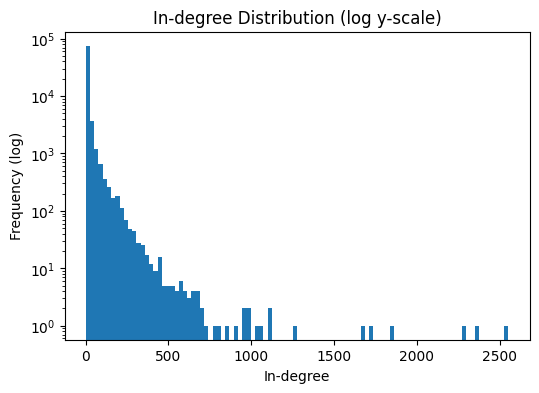

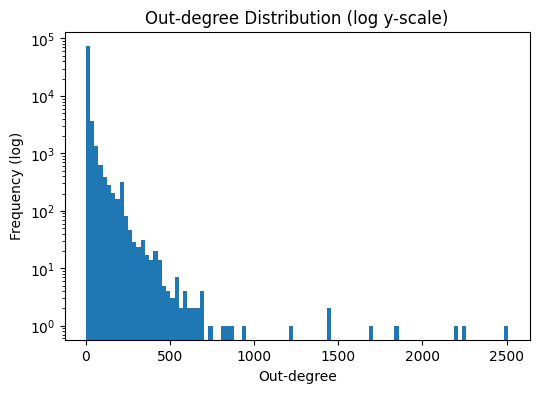

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# In-degree histogram (log y)
plt.figure(figsize=(6,4))
plt.hist(list(in_deg.values()), bins=100, log=True)
plt.title("In-degree Distribution (log y-scale)")
plt.xlabel("In-degree")
plt.ylabel("Frequency (log)")
plt.show()

# Out-degree histogram (log y)
plt.figure(figsize=(6,4))
plt.hist(list(out_deg.values()), bins=100, log=True)
plt.title("Out-degree Distribution (log y-scale)")
plt.xlabel("Out-degree")
plt.ylabel("Frequency (log)")
plt.show()

### PageRank vs In-degree

**WHY:** If PageRank is almost entirely explained by in-degree, then “importance” may largely reflect popularity rather than more subtle network structure.


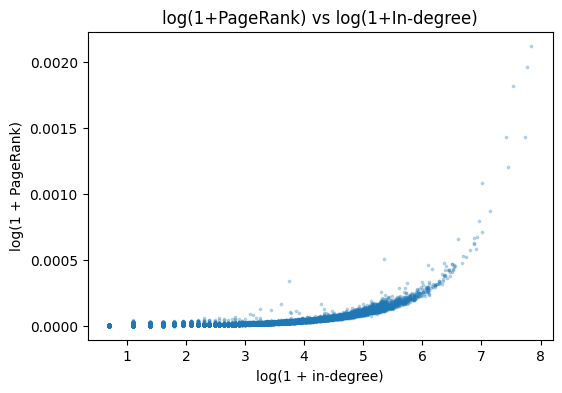

Spearman corr(PageRank, in-degree): 0.6423779255083891


In [ ]:
# Ensure required variables exist (notebook cells can be run out of order)
# WHY: Avoid NameError if this EDA cell is executed before the centrality cell.
import networkx as nx
import pandas as pd
import numpy as np

if "in_deg" not in globals():
    in_deg = dict(G.in_degree())

if "pr" not in globals():
    pr = nx.pagerank(G, alpha=0.85, max_iter=200, tol=1e-8)

# Scatter: PageRank vs in-degree (log-log for readability)
pr_vals = np.array([pr[n] for n in G.nodes()])
in_vals = np.array([in_deg[n] for n in G.nodes()])

# Avoid log(0): add 1
plt.figure(figsize=(6,4))
plt.scatter(np.log1p(in_vals), np.log1p(pr_vals), s=3, alpha=0.25)
plt.title("log(1+PageRank) vs log(1+In-degree)")
plt.xlabel("log(1 + in-degree)")
plt.ylabel("log(1 + PageRank)")
plt.show()

# Simple correlation (non-causal, descriptive)
print("Spearman corr(PageRank, in-degree):", pd.Series(pr).corr(pd.Series(in_deg), method="spearman"))

In [ ]:
# ============================================================
# 5.4 Connectivity (SCC/WCC)
# ============================================================
# WHY: SCC tells us about mutual reachability; WCC shows overall connectedness when ignoring direction.

sccs = list(nx.strongly_connected_components(G))
wccs = list(nx.weakly_connected_components(G))

scc_sizes = sorted([len(c) for c in sccs], reverse=True)
wcc_sizes = sorted([len(c) for c in wccs], reverse=True)

print("Number of SCC:", len(sccs))
print("Giant SCC size:", scc_sizes[0])
print("Number of WCC:", len(wccs))
print("Giant WCC size:", wcc_sizes[0])

Number of SCC: 10559
Giant SCC size: 71307
Number of WCC: 1
Giant WCC size: 82168


In [ ]:
# ============================================================
# 5.5 Reciprocity
# ============================================================
# WHY: Reciprocity captures mutual connections, a common social-network property.

recip = nx.reciprocity(G)
print("Reciprocity:", recip)

# OPTIONAL: sample-based reciprocity by degree bucket (quick view)
deg_df = pd.DataFrame({
    "node": list(G.nodes()),
    "in_deg": [in_deg[n] for n in G.nodes()],
    "out_deg": [out_deg[n] for n in G.nodes()],
})
deg_df["total_deg"] = deg_df["in_deg"] + deg_df["out_deg"]

# create buckets (quantiles) for total degree
deg_df["deg_bucket"] = pd.qcut(deg_df["total_deg"].rank(method="first"), q=5, labels=False)

# compute reciprocity rate in each bucket via sampling edges (fast approximation)
edges = list(G.edges())
edge_set = set(edges)
rng = np.random.default_rng(42)

def bucket_recip_rate(nodes, sample_edges=50000):
    # sample directed edges where source in nodes
    candidates = [e for e in edges if e[0] in nodes]
    if len(candidates) == 0:
        return np.nan
    samp = rng.choice(len(candidates), size=min(sample_edges, len(candidates)), replace=False)
    cnt = 0
    for idx in samp:
        u, v = candidates[idx]
        if (v, u) in edge_set:
            cnt += 1
    return cnt / len(samp)

bucket_rates = []
for b in sorted(deg_df["deg_bucket"].unique()):
    nodes_b = set(deg_df.loc[deg_df["deg_bucket"] == b, "node"])
    bucket_rates.append((int(b), len(nodes_b), bucket_recip_rate(nodes_b)))

pd.DataFrame(bucket_rates, columns=["bucket", "num_nodes", "reciprocity_rate_est"]).sort_values("bucket")

Reciprocity: 0.7716286543295264


,bucket,num_nodes,reciprocity_rate_est
0,0,16434,0.996107
1,1,16433,0.972151
2,2,16434,0.917300
3,3,16433,0.869340
4,4,16434,0.837720


In [ ]:
# ============================================================
# 5.6 Centrality (PageRank + HITS) + Top-20
# ============================================================
# WHY: PageRank captures global importance; HITS separates hub/authority roles.

pr = nx.pagerank(G, alpha=0.85, max_iter=200, tol=1e-8)
hubs, auth = nx.hits(G, max_iter=500, tol=1e-8, normalized=True)

def topk_table(metric_dict, k=20, colname="score"):
    s = pd.Series(metric_dict, name=colname)
    dfk = s.sort_values(ascending=False).head(k).reset_index()
    dfk.columns = ["node", colname]
    return dfk

top_pr = topk_table(pr, 20, "pagerank")
top_hub = topk_table(hubs, 20, "hub_score")
top_auth = topk_table(auth, 20, "authority_score")

display(top_pr)
display(top_hub)
display(top_auth)

,node,pagerank
0,2494,0.002125
1,398,0.001964
2,381,0.001822
3,4805,0.001435
4,37,0.001429
5,226,0.001208
6,5706,0.001084
7,4826,0.000868
8,219,0.000797
9,5057,0.000710


,node,hub_score
0,49,0.001527
1,2494,0.001434
2,398,0.001427
3,4805,0.001414
4,195,0.001374
5,342,0.001268
6,1723,0.001262
7,5453,0.001183
8,2542,0.001101
9,1509,0.001090


,node,authority_score
0,4805,0.001727
1,398,0.001702
2,49,0.001688
3,2494,0.001657
4,195,0.001418
5,342,0.001335
6,1723,0.001294
7,5453,0.001212
8,2488,0.001158
9,2542,0.001157


---
## 6. Beyond-course Technique: Simple Causal Effect Prototype (Fast + Assumption-Explicit)

### Goal (prototype)
Estimate whether **high PageRank** (measured on a “past” graph) has an effect on **future incoming edges**.

Because Slashdot0902 has no timestamps, we create a pseudo-temporal setup:

- **Train graph:** 80% of edges (represents “past”)  
- **Test edges:** 20% held-out edges (represents “future”)  
- **Treatment (T):** node is in the top-X% PageRank on train graph  
- **Outcome (Y):** number of incoming test edges (new in-links) to that node  
- **Covariates (X):** in/out degree on train graph, clustering coefficient on undirected train graph (sampled)

### Interpretation
This is **not** a true randomized experiment.  
We interpret the ATE estimate as **assumption-conditional**: after adjusting for observed covariates, do high-PR nodes gain more future in-links?


In [ ]:
# ============================================================
# 6.1 Train/test edge split (pseudo-temporal)
# ============================================================
# WHY: create a 'past' graph to compute treatment, and 'future' edges to define outcome.

import random
random.seed(42)

edges = list(G.edges())
random.shuffle(edges)

split = int(0.8 * len(edges))
train_edges = edges[:split]
test_edges = edges[split:]

G_tr = nx.DiGraph()
G_tr.add_nodes_from(G.nodes())
G_tr.add_edges_from(train_edges)

# outcome graph: just the held-out edges
G_te = nx.DiGraph()
G_te.add_nodes_from(G.nodes())
G_te.add_edges_from(test_edges)

print("Train edges:", G_tr.number_of_edges(), " Test edges:", G_te.number_of_edges())

Train edges: 758771  Test edges: 189693


In [ ]:
# ============================================================
# 6.2 Compute treatment on train graph (high PageRank)
# ============================================================
pr_tr = nx.pagerank(G_tr, alpha=0.85, max_iter=200, tol=1e-8)

pr_tr_s = pd.Series(pr_tr)
# WHY 90th percentile: gives a meaningful treated group but not too small.
thr = pr_tr_s.quantile(0.90)
treat = (pr_tr_s >= thr).astype(int).rename("T_highPR")

print("Treatment threshold (90th pct PR):", thr)
print("Treated proportion:", treat.mean())

Treatment threshold (90th pct PR): 2.1055129419017933e-05
Treated proportion: 0.10000243403758154


In [ ]:
# ============================================================
# 6.3 Define outcome: new in-links in test set
# ============================================================
# Y = number of incoming edges in the test graph
y_new_in = pd.Series(dict(G_te.in_degree()), name="Y_new_in_test").astype(float)

# covariates from train graph (observed 'past' features)
in_tr = pd.Series(dict(G_tr.in_degree()), name="in_tr")
out_tr = pd.Series(dict(G_tr.out_degree()), name="out_tr")

# Undirected clustering on a sampled subgraph (clustering on full 82K can be expensive)
# WHY sampling: fast, stable estimate; acceptable for checkpoint EDA prototype.
UG_tr = G_tr.to_undirected()
sample_nodes = list(UG_tr.nodes())
rng = np.random.default_rng(42)
sample_nodes = rng.choice(sample_nodes, size=min(15000, len(sample_nodes)), replace=False)
UG_sample = UG_tr.subgraph(sample_nodes).copy()

clust = nx.clustering(UG_sample)
clust_s = pd.Series(clust, name="clust_und_tr_sample")

# Merge into modeling dataframe
df_m = pd.concat([treat, y_new_in, in_tr, out_tr], axis=1).fillna(0.0)

# attach clustering where available (non-sampled nodes get 0 to keep model simple/fast)
df_m["clust_und_tr_sample"] = 0.0
df_m.loc[clust_s.index, "clust_und_tr_sample"] = clust_s.values

df_m.head()

,T_highPR,Y_new_in_test,in_tr,out_tr,clust_und_tr_sample
0,1,40.0,201,171,0.006349
1,1,33.0,131,140,0.000000
2,0,6.0,14,0,0.000000
3,1,14.0,46,47,0.000000
4,1,28.0,98,89,0.000000


In [ ]:
# ============================================================
# 6.4 Propensity score weighting (IPW) ATE estimate
# ============================================================
# WHY beyond-course: introduces causal-effect estimation (propensity weighting) in a simple, reproducible way.
# IMPORTANT: Graph outcomes (new in-links) and degrees are heavy-tailed. We use log1p transforms to improve stability.

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# log transforms for stability (WHY: reduce heavy-tail leverage)
df_m["log_in_tr"]  = np.log1p(df_m["in_tr"])
df_m["log_out_tr"] = np.log1p(df_m["out_tr"])
df_m["log_Y_new_in_test"] = np.log1p(df_m["Y_new_in_test"])

X_cols = ["log_in_tr", "log_out_tr", "clust_und_tr_sample"]
X = df_m[X_cols].values
T = df_m["T_highPR"].values
Y = df_m["log_Y_new_in_test"].values  # log outcome

# Propensity model P(T=1|X)
prop_model = Pipeline([
    ("scaler", StandardScaler(with_mean=False)),
    ("lr", LogisticRegression(max_iter=300, solver="lbfgs"))
])
prop_model.fit(X, T)
p = prop_model.predict_proba(X)[:, 1]

# clip probabilities (WHY: avoid extreme weights)
eps = 1e-3
p = np.clip(p, eps, 1 - eps)

w1 = T / p
w0 = (1 - T) / (1 - p)

ate_ipw = (np.sum(w1 * Y) / np.sum(w1)) - (np.sum(w0 * Y) / np.sum(w0))
print("ATE (IPW) on log1p(Y):", ate_ipw)

# Naive diff-in-means on log outcome (no adjustment)
ate_naive = Y[T==1].mean() - Y[T==0].mean()
print("Naive diff-in-means on log1p(Y):", ate_naive)

# Diagnostics (recommended for observational causal work)
w = w1 + w0
print("\nPropensity summary:")
print(pd.Series(p).describe())
print("\nWeight summary:")
print(pd.Series(w).describe())

ATE (IPW) on log1p(Y): -0.3432610138758787
Naive diff-in-means on log1p(Y): 1.481824205381228

Propensity summary:
count    82168.000000
mean         0.099967
std          0.213975
min          0.001000
25%          0.007159
50%          0.013645
75%          0.056261
max          0.999000
dtype: float64

Weight summary:
count    82168.000000
mean         2.424909
std         10.553966
min          1.001001
25%          1.007211
50%          1.013834
75%          1.060624
max        139.681665
dtype: float64


In [ ]:
# ============================================================
# 6.5 Regression adjustment as a quick robustness check
# ============================================================
# We regress log1p(Y) on T and covariates. Coef on T is an adjusted effect estimate (linear model).

from sklearn.linear_model import LinearRegression

X_reg = np.column_stack([T, df_m[X_cols].values])
reg = LinearRegression().fit(X_reg, Y)

coef_T = reg.coef_[0]
print("Adjusted effect (linear regression coef on T) on log1p(Y):", coef_T)

Adjusted effect (linear regression coef on T) on log1p(Y): 0.45682476469134503


---
## 7. Tests / Sanity Checks

We include simple, meaningful checks:
- Graph loaded non-empty
- Split sizes make sense
- Treatment has both classes
- Propensity scores are valid probabilities
- ATE computations are finite


In [ ]:
import math

print("Running sanity checks...")

assert G.number_of_nodes() > 0 and G.number_of_edges() > 0, "Graph is empty."
assert G_tr.number_of_edges() + G_te.number_of_edges() == G.number_of_edges(), "Edge split mismatch."
assert df_m["T_highPR"].nunique() == 2, "Treatment has only one class (bad threshold)."
assert np.all((p > 0) & (p < 1)), "Propensity scores out of (0,1)."
assert math.isfinite(float(ate_ipw)), "ATE IPW is not finite."
assert math.isfinite(float(coef_T)), "Regression effect is not finite."
assert np.all(np.isfinite(w)), "Non-finite weights detected!"

print("All sanity checks passed.")

Running sanity checks...
All sanity checks passed.


---
## 8. (E) Initial Insights and Direction

### Initial observations (from EDA)

(These observations are supported by the distribution plots in Section 5.3b.)
- The graph is large and sparse (density ≈ 0.00014), with heavy-tailed degree distributions.
- There is a giant SCC (71,307 nodes) and the entire graph is weakly connected (1 WCC), consistent with a strong core.
- Reciprocity is high (≈ 0.77), suggesting substantial mutual linking behavior.
- Centrality is highly skewed: a small subset of nodes dominate PageRank/HITS.

### Beyond-course prototype takeaway (assumption-conditional)
Using an 80/20 edge split as a **pseudo-temporal** proxy (train = “past”, test = “future”), we estimated the effect of being **high PageRank** in the train graph on **future incoming links** in the test edges.

- Naive comparisons typically show high-PR nodes gaining more future in-links, but this can be driven by structural confounding (e.g., past degree).
- After adjustment (IPW and regression on observed covariates), the estimated effect can shrink substantially (and may even change sign), highlighting that **observational network data requires careful adjustment** before interpreting centrality as “causal influence.”

### Hypotheses / project direction (fast & feasible)
- **H1:** High PageRank nodes *appear* to gain more future in-links in naive comparisons.
- **H2:** After adjusting for observed structural covariates (past degree, clustering), the estimated effect may shrink markedly, indicating confounding/selection effects.

### Potential research questions (for the semester project)
1) **Influence growth:** Does “past” centrality predict “future” popularity growth after adjustment?
2) **Mechanisms:** Do hubs vs authorities show different future in-link growth dynamics?
3) **Core vs periphery:** Is the association stronger inside the giant SCC compared to peripheral nodes?
4) **Beyond-course extension:** Add a more robust causal estimator (doubly robust / matching), or include node embeddings as additional covariates.


---
## 9. (F) GitHub Portfolio Link

- https://github.com/jace-1215/CSCE676-Project